In [83]:
from torch.utils.data import DataLoader
import pandas as pd
import torch as th 
import tqdm
import torch.nn as nn
import open_clip

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import train_test_split
import numpy as np
import PIL
import torchvision.transforms.functional as F
from torchvision.utils import make_grid
import torchvision.transforms as T

import sys

import utilities
sys.path.append('..')
import src.data_loader as dl

%matplotlib inline  
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
class CFG:
    model_name = 'ViT-L-14' 
    model_data = 'datacomp_xl_s13b_b90k'
    samples_per_class = 5
    n_classes = 6
    min_samples = 1
    image_size = 224 
    hidden_layer = 768
    seed = 5
    workers = 12
    train_batch_size = 16
    valid_batch_size = 32 
    emb_size = 512
    vit_bb_lr = {"8": 1.25e-6, "16": 2.5e-6, "20": 5e-6, "24": 10e-6}
    vit_bb_wd = 1e-3
    hd_lr = 3e-4
    hd_wd = 1e-5
    autocast = True
    n_warmup_steps = 1000
    n_epochs = 20
    device = th.device('cuda')
    s=30.
    m=.45
    m_min=.05
    acc_steps = 1
    global_step = 0
    crit = 'ce'
    version='v2'

In [90]:
PIL.Image.MAX_IMAGE_PIXELS = 108000001

In [91]:
def plot_confusion(y_t, y_p, labels):
    cm = confusion_matrix(y_t, y_p)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
    
    
@th.no_grad()
def predict(model, data_loader):
    y_t, y_p = [], []
    
    for bs in tqdm.tqdm(data_loader):
        x = bs['img'].cuda().half()
        y_t.append(bs['label'].argmax(dim=1).detach().cpu().numpy())
        p, _ = model(x)
        y_p.append(p.argmax(dim=1).detach().cpu().numpy())
        
    return np.concatenate(y_t), np.concatenate(y_p)

In [92]:
def get_final_transform():  
    final_transform = T.Compose([
            T.ToPILImage(),
            T.Resize(
                size=(CFG.image_size, CFG.image_size), 
                interpolation=T.InterpolationMode.BICUBIC,
                antialias=True),
            T.ToTensor(), 
            T.Normalize(
                mean=(0.48145466, 0.4578275, 0.40821073), 
                std=(0.26862954, 0.26130258, 0.27577711)
            )
        ])
    return final_transform

In [93]:
model_folder = 'ViT-L-14-datacomp_xl_s13b_b90k-hca-v2-cosine-mosquito-epoch(20)-k(3)'
model_name = 'model_epoch_11_f1_score_0.68'

model_checkpoint = f'./my_experiments/{model_folder}/{model_name}.pt'

img_dir = "../../data_round_2/final"
annotations_csv = "../../data_round_2/phase2_train_v0.csv"

class_dict = {
    "albopictus": th.tensor([1, 0, 0, 0, 0, 0], dtype=th.float),
    "culex": th.tensor([0, 1, 0, 0, 0, 0], dtype=th.float),
    "japonicus/koreicus": th.tensor([0, 0, 1, 0, 0, 0], dtype=th.float),
    "culiseta": th.tensor([0, 0, 0, 1, 0, 0], dtype=th.float),
    "anopheles": th.tensor([0, 0, 0, 0, 1, 0], dtype=th.float),
    "aegypti": th.tensor([0, 0, 0, 0, 0, 1], dtype=th.float),
}

labels = list(class_dict.keys())
transform = get_final_transform()
bs = 256

# Model

In [94]:
class Head(nn.Module):
    def __init__(self, hidden_size, k=3):
        super(Head, self).__init__()
        self.emb = nn.Linear(hidden_size, CFG.emb_size, bias=False)
        self.dropout = utilities.Multisample_Dropout()
        self.arc = utilities.ArcMarginProduct_subcenter(CFG.emb_size, CFG.n_classes, k)
        
    def forward(self, x):
        embeddings = self.dropout(x, self.emb)
        output = self.arc(embeddings)
        return output, embeddings
    
class HeadV2(nn.Module):
    def __init__(self, hidden_size, k=3):
        super(HeadV2, self).__init__()
        self.arc = utilities.ArcMarginProduct_subcenter(hidden_size, CFG.n_classes, k)
        
    def forward(self, x):
        output = self.arc(x)
        return output, x
    

class Model(nn.Module):
    def __init__(self, vit_backbone, head_size, version='v1', k=3):
        super(Model, self).__init__()
        if version == 'v1':
            self.head = Head(head_size, k)
        elif version == 'v2':
            self.head = HeadV2(head_size, k)
        else:
            self.head = Head(head_size, k)
        
        self.encoder = vit_backbone.visual
    def forward(self, x):
        x = self.encoder(x)
        return self.head(x)


In [95]:
backbone, _, _ = open_clip.create_model_and_transforms(CFG.model_name, CFG.model_data)
model = Model(backbone, CFG.hidden_layer, CFG.version, 3)
model.load_state_dict(th.load(model_checkpoint)['model_state_dict'])
model.cuda()
model.eval()
model.half()

Model(
  (head): HeadV2(
    (arc): ArcMarginProduct_subcenter()
  )
  (encoder): VisionTransformer(
    (patchnorm_pre_ln): Identity()
    (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-23): 24 x ResidualAttentionBlock(
          (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
          )
        

# Dataloader

In [96]:
annotations_df = pd.read_csv(annotations_csv)
train_df, val_df = train_test_split(
    annotations_df,
    test_size=0.2,
    stratify=annotations_df["class_label"],
    random_state=200,
)

val_df = val_df[val_df['img_fName'].str.contains(r"train_\d+.jpeg")]

train_dataset = dl.SimpleClassificationDataset(
    train_df,
    img_dir,
    class_dict,
    transform,
    None,
    class_balance=False,
)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=bs,
    shuffle=False,
    num_workers=6,
)

val_dataset = dl.SimpleClassificationDataset(
    val_df,
    img_dir,
    class_dict,
    transform,
    None,
    class_balance=False,
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=bs,
    shuffle=False, 
    drop_last=False,
    num_workers=6,
)

In [97]:
v_t, v_p = predict(model, val_dataloader)

100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:32<00:00,  3.56s/it]


0.7018698334719063

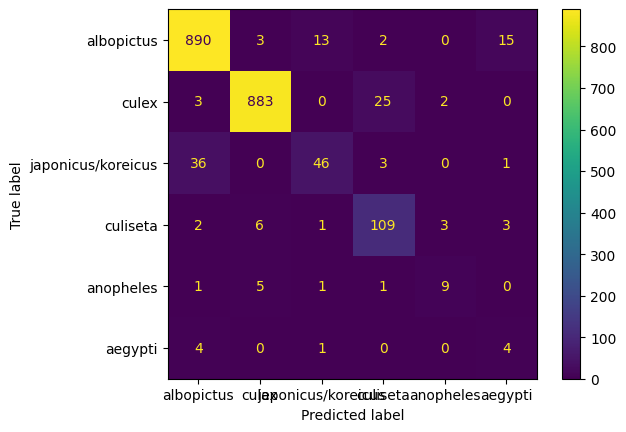

In [98]:
plot_confusion(v_t, v_p, labels)
f1_score(v_t, v_p, average='macro')

100%|████████████████████████████████████████████████████████████████████████████████| 33/33 [01:37<00:00,  2.96s/it]


0.7942664685290821

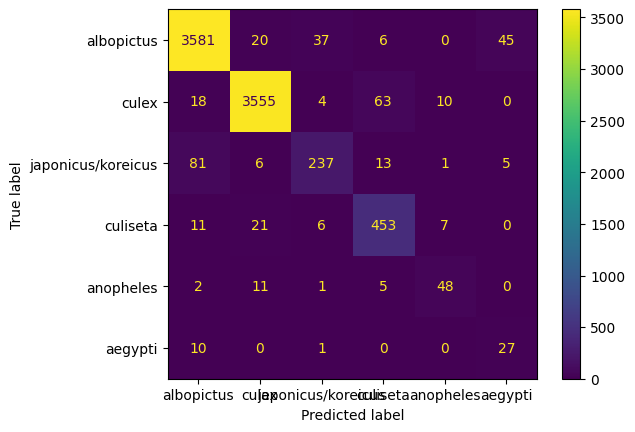

In [99]:
t_t, t_p = predict(model, train_dataloader)
plot_confusion(t_t, t_p, labels)

f1_score(t_t, t_p, average='macro')

# FAILED CASES

In [100]:
genus = ["anopheles", "culex", "culiseta"]
species = ["aegypti", "albopictus", "japonicus/koreicus"]

df = val_df.copy()
df['label'] = v_t
df['pred'] = v_p
df['correct_match'] = v_t == v_p
df['label_type'] = df['class_label'].isin(genus).map({True: 'genus', False: 'species'})
df['predicted_type'] = df['pred'].isin([1, 3, 4]).map({True: 'genus', False: 'species'})
cls_missed = df[df.correct_match == False]


len(cls_missed), len(cls_missed[cls_missed.label_type == cls_missed.predicted_type])

(131, 112)

Text(0.5, 1.0, 'Miss Classification of CLIP-ViT-L-14')

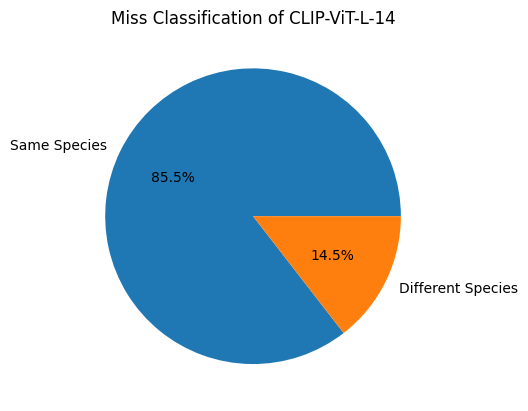

In [101]:
labels = 'Same Species', 'Different Species'
sizes = [
    len(cls_missed[cls_missed.label_type == cls_missed.predicted_type]),
    len(cls_missed[cls_missed.label_type != cls_missed.predicted_type])
]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Miss Classification of CLIP-ViT-L-14')

In [102]:
failed_cases = DataLoader(
    dl.SimpleClassificationDataset(
        val_df[
        (df.label_type != df.predicted_type) 
        & (df.label != df.pred)
        ],
        img_dir,
        class_dict,
        T.ToTensor(),
        dl.aug("resize"),
        class_balance=False,
    ),
    batch_size=256,
    shuffle=False,
    num_workers=6,
)
grid = make_grid(next(iter(failed_cases))['img'], nrow=16)

In [103]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

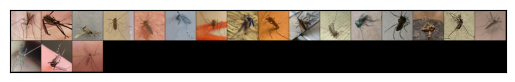

In [104]:
show(grid)

# TSNE Visualization

In [107]:
@th.no_grad()
def extract_embeddings(model, data_loader):
    embs, y_t = [], []

    
    for bs in tqdm.tqdm(data_loader):
        x = bs['img'].cuda().half()

        _, emb = model(x)
        y_t.append(bs['label'].argmax(dim=1).detach().cpu().numpy())
        embs.append(emb.detach().cpu().numpy())
        
    return np.concatenate(embs), np.concatenate(y_t)

In [108]:
emb, t = extract_embeddings(model, val_dataloader)

100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:32<00:00,  3.61s/it]


In [109]:
el, c = np.unique(t, return_counts=True)

In [110]:
from sklearn.manifold import TSNE


tsne = TSNE(n_components=2, random_state=200, n_jobs=-1)
tsne_emb = tsne.fit_transform(emb)

Text(0.5, 1.0, 'TNSE ViT-L-14 Embeddings')

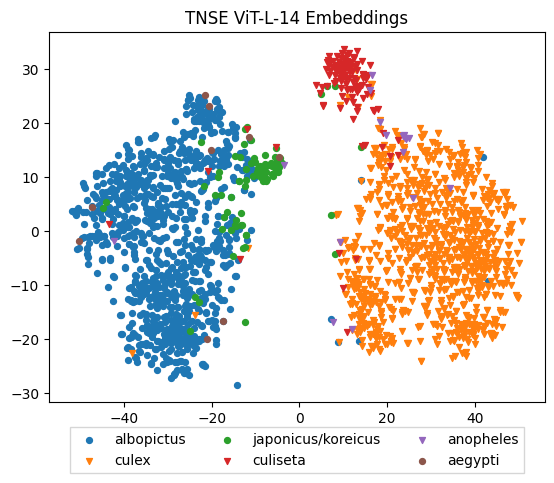

In [111]:
names = list(class_dict.keys())

for e in  el:
    idx = np.where(t == e)[0]
    
    plt.scatter(tsne_emb[idx, 0], 
                tsne_emb[idx, 1], 
                label=names[int(e)],
                marker='v' if names[int(e)] in genus else 'o',
                s=18
                )
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=False, ncol=3)
plt.title('TNSE ViT-L-14 Embeddings')